In [1]:
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms.functional as T
from matplotlib import pyplot as plt
from torchvision.utils import draw_segmentation_masks, make_grid
import pytorch_lightning as pl

In [2]:
from inz.data.event import Tier1, Tier3, Test, Hold, Subset, Event
from inz.data.data_module import Event, Hold, Test, Tier1, Tier3, XBDDataModule

In [3]:
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)
device = torch.device("cuda")
torch.set_float32_matmul_precision("high")

Seed set to 123


In [4]:
dm1 = XBDDataModule(
    path=Path("data/xBD_processed"),
    events={
        # Tier1: [
        #     Event.hurricane_florence,
        #     Event.hurricane_harvey,
        #     Event.hurricane_matthew,
        #     Event.hurricane_michael,
        # ],
        Tier3: [
            Event.joplin_tornado,
            # Event.moore_tornado,
            # Event.tuscaloosa_tornado
        ],
        # Hold: [
        #     Event.hurricane_florence,
        #     Event.hurricane_harvey,
        #     Event.hurricane_matthew,
        #     Event.hurricane_michael,
        # ],
        # Test: [
        #     Event.hurricane_florence,
        #     Event.hurricane_harvey,
        #     Event.hurricane_matthew,
        #     Event.hurricane_michael,
        # ],
    },
    val_faction=0.15,
    test_fraction=0.0,
    train_batch_size=32,
    val_batch_size=32,
    test_batch_size=32,
)
dm1.prepare_data()
dm1.setup("fit")

def hash_tensor(x: torch.Tensor) -> torch.Tensor:
    return hash(tuple(x.reshape(-1).tolist()))

train_dl = dm1.train_dataloader()
val_dl = dm1.val_dataloader()


In [5]:
plt.rcParams["savefig.bbox"] = "tight"


def show(imgs: list[torch.Tensor]):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = T.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [6]:
dm = XBDDataModule(
    path=Path("data/xBD_processed"),
    events={
        Tier1: [
            Event.hurricane_harvey,
            Event.santa_rosa_wildfire,
            Event.palu_tsunami,
        ],
        Tier3: list(Tier3.events),
        Hold: list(Hold.events),
        Test: list(Test.events),
    },
    val_faction=0.1,
    test_fraction=0.1,
    train_batch_size=16,
)

In [7]:
dm.prepare_data()
dm.setup("fit")
loader_iter = iter(dm.train_dataloader())

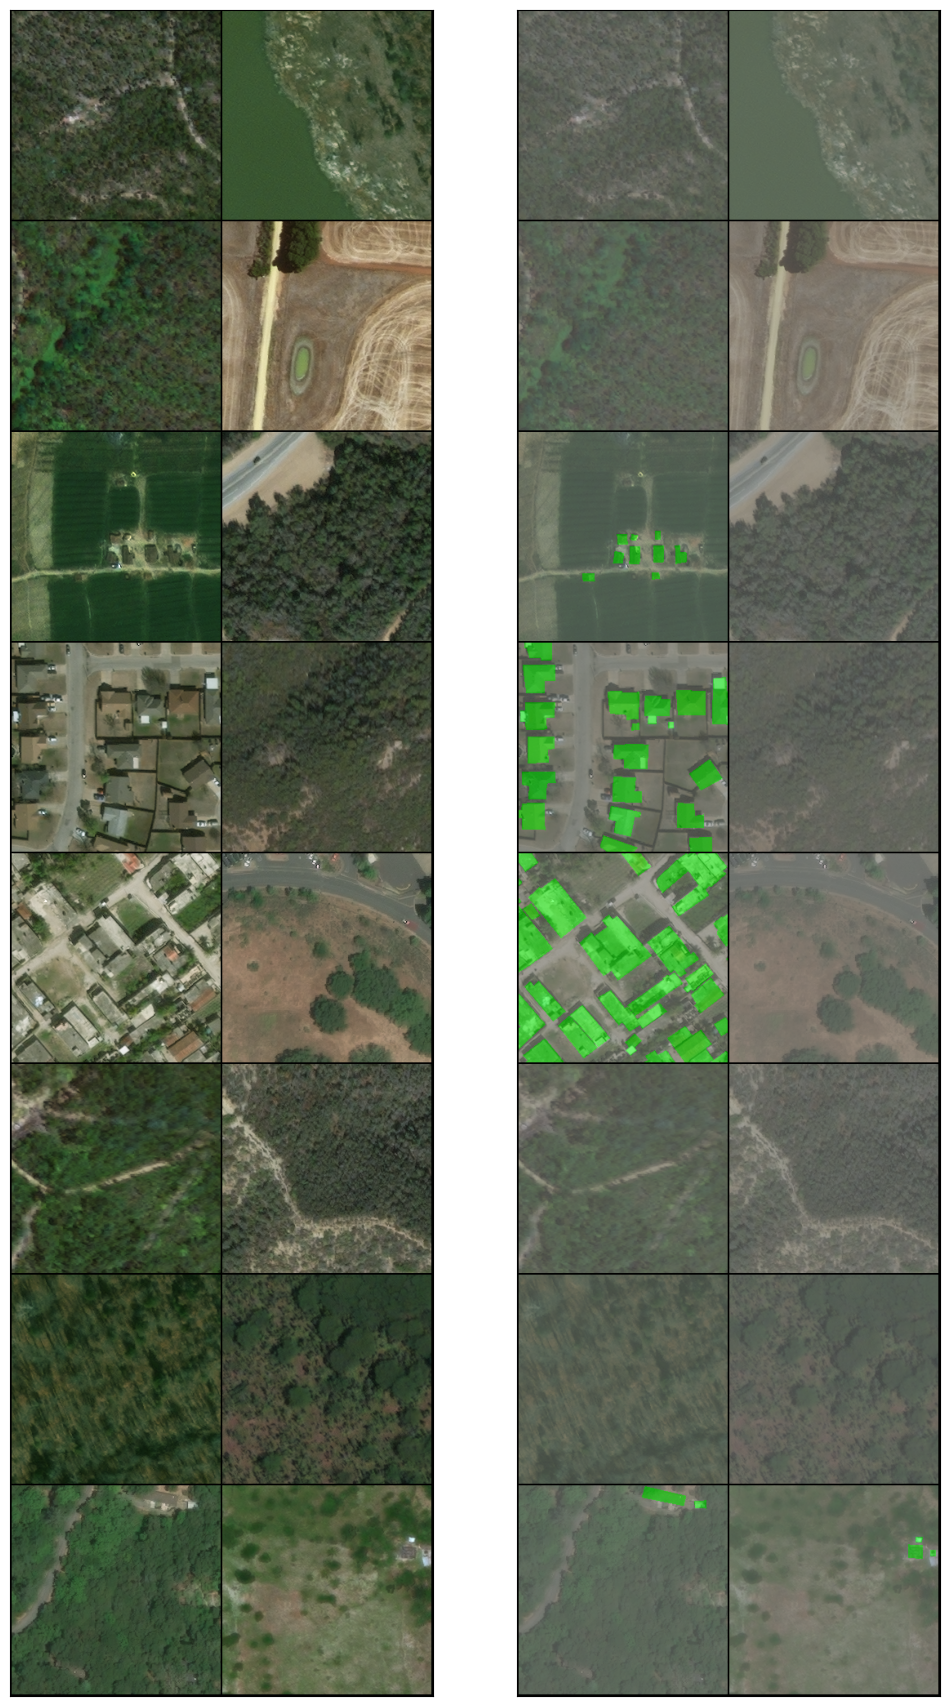

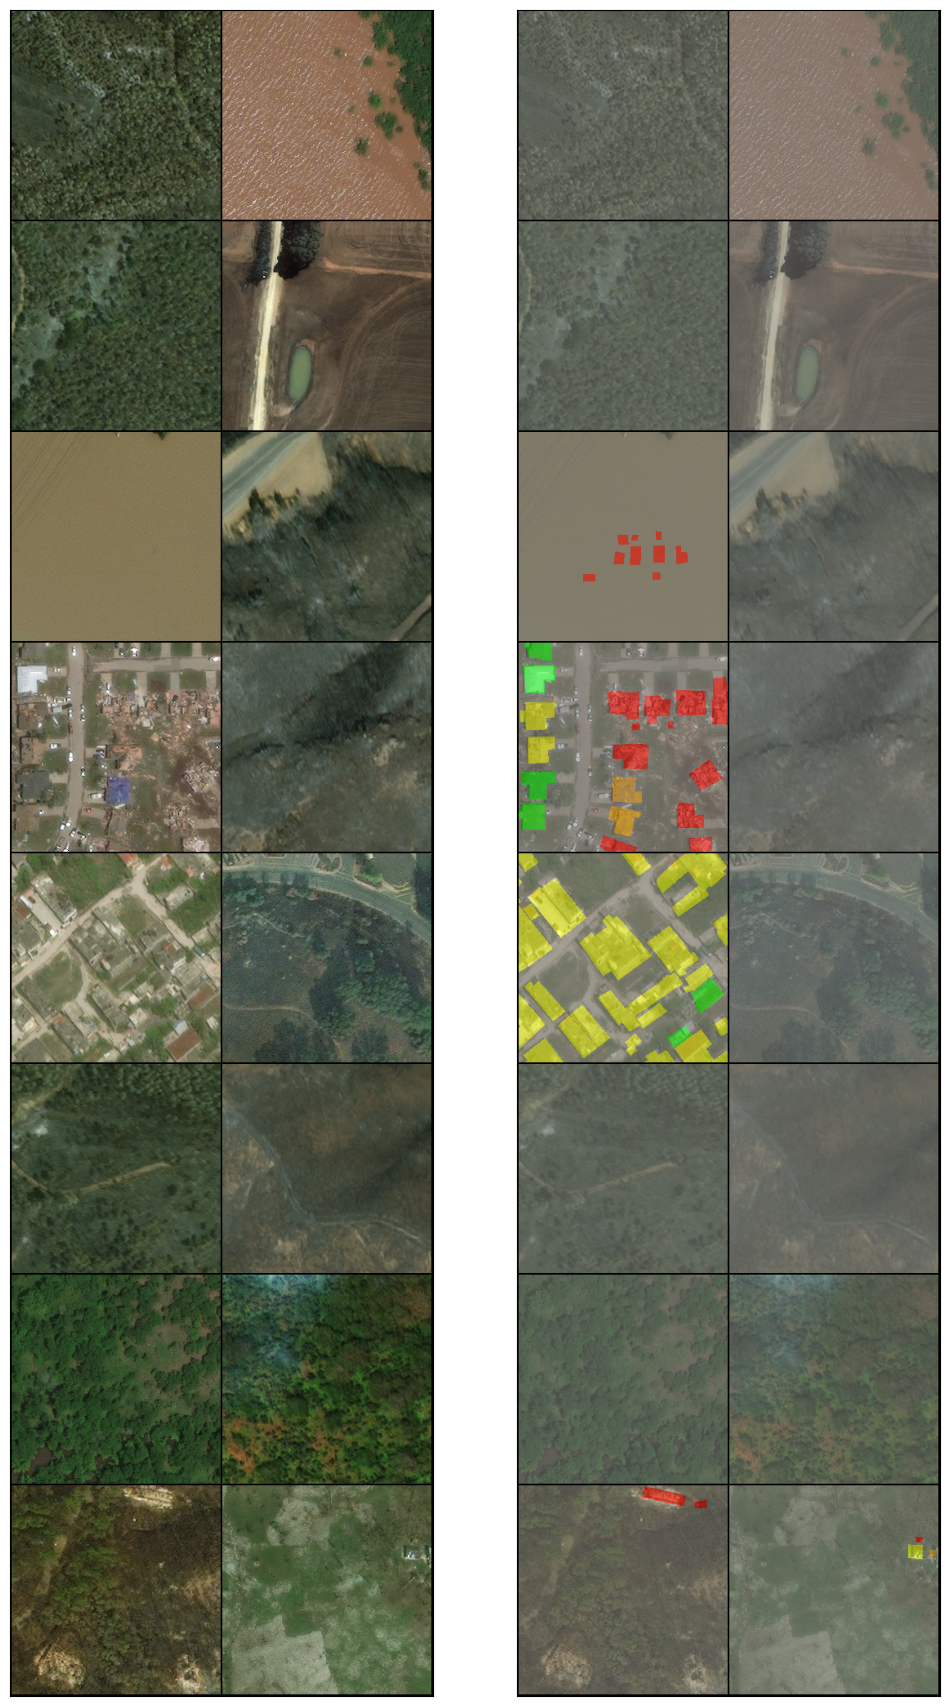

In [15]:
plt.rcParams["figure.figsize"] = [12, 24]
images_pre, masks_pre, images_post, masks_post = next(loader_iter)
colors = [
    (128, 128, 128),
    (0, 255, 0),
    (244, 255, 0),
    (255, 174, 0),
    (255, 0, 0),
    (255, 255, 255),
]
for images, masks in ((images_pre, masks_pre), (images_post, masks_post)):
    show(
        [
            make_grid((images + 1) / 2, nrow=2),
            make_grid(
                [draw_segmentation_masks(((i + 1) * 127.5).to(torch.uint8), m, colors=colors, alpha=0.5) for i, m in zip(images, masks.to(torch.bool))], nrow=2
            ),
        ]
    )